In [ ]:
### Anime Face Generation

In [ ]:
## refered from https://www.kaggle.com/code/hannukoivisto/gan-anime-faces

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1334 sha256=48dc5775c9351e44dbe01ae23776ddaa965dda75db41cc643fc20ac6152f898c
  Stored in directory: /root/.cache/pip/wheels/c5/05/b3/f7b36dbaaf76de31b718cde792c953bfd11d2414a72f204b56
Successfully built unzip


In [ ]:
!unzip    gdrive/My\ Drive/ANIEME-FACES-DATA.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [ ]:
pip install denorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch, torchvision
from torch.utils.data import DataLoader , Dataset 
from torchvision.datasets import ImageFolder
from torchvision import transforms 
from torch import nn , optim 
from torchvision.utils import make_grid 
from torchvision.utils import save_image
from tqdm.notebook import tqdm 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import os 
import glob 
import random
import denorm
import cv2
from PIL import Image
%matplotlib inline 
def show_images(images,nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0) )

In [ ]:
!mkdir anime

In [ ]:
# defile dataset addresss
root = 'anime'

In [ ]:
# Visualize the input image
# randomly choose images to visualize
img_list = []
for root, dirs, files in os.walk(root, topdown=False):
    for name in files:
        img = os.path.join(root, name)
        img_list.append(img)
print(len(img_list))



63565


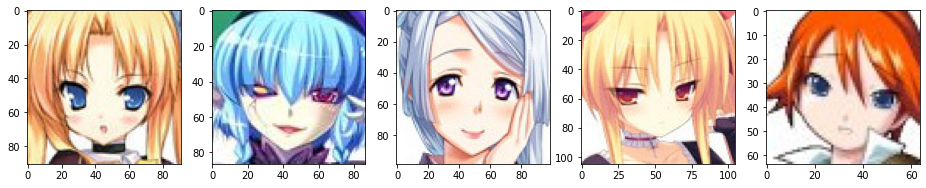

In [ ]:
r_idx = random.sample(range(0,36740),5)
plt.figure(figsize=(16,8))
for i in range(len(r_idx)):
    img = Image.open(img_list[r_idx[i]])
    plt.subplot(1,5,i+1)
    plt.imshow(img)


In [ ]:
# Load the data 
batch_size = 64
stats = (0.5,0.5,0.5) , (0.5,0.5,0.5)
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])
def denorm(img_tensors):
  return img_tensors * stats[1][0] * stats[0][0]

# Dataset and DataLoader

class AnimeData(Dataset):
  """
    Wrap the data into a Dataset class, and then pass it to the DataLoader
    :__init__: Initialization data
    :__getitem__: support the indexing such that dataset[i] can be used to get ith sample
    :__len__: return the size of the dataset.
  """

  def __init__(self,root,transform=None):
    self.transform = transform 
    self.data = ImageFolder(root,self.transform)
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index):
    return self.data[index][0]

# Trainloader
trainset = AnimeData(root,transform = transform)
trainloader = DataLoader(trainset,batch_size=64,shuffle=True, num_workers=0    )

                                
                              

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

<h2> GAN </h2>

In [ ]:
## Discriminator model


class Discriminator(nn.Module):
    def __init__(self,inchannels):
        super(Discriminator,self).__init__()
        """
        Initialize the Discriminator Module
        :param inchannels: The depth of the first convolutional layer
        """
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )
        
    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        x = self.seq(x)
        
        return x


        
D=Discriminator(3).to(device)
    

In [ ]:
# Generator 
latent_size = 128
class Generator(nn.Module):
  def __init__(self,latent_size):
    super(Generator,self).__init__()
    """
    Initialize the Generator module
    """
    self.seq = nn.Sequential(
        nn.ConvTranspose2d(
        in_channels=latent_size,out_channels=512,kernel_size=4,
        stride=1,padding=0,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,
                           stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,
                           stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=4,stride=2,padding=1,bias=False),
        nn.Tanh()

    )
  def forward(self,x):
    """
    Forowrd propogation
    """
    x = self.seq(x)
    return x

torch.Size([64, 3, 64, 64])


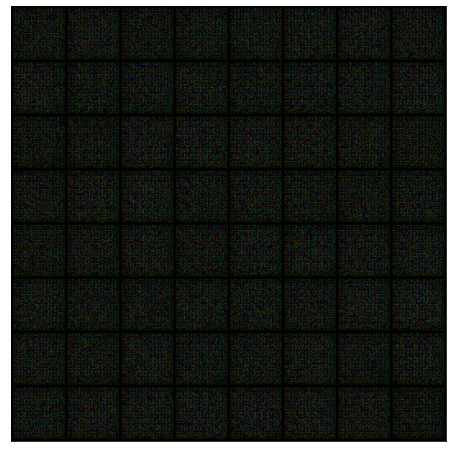

In [ ]:
G = Generator(latent_size).to(device) 
#random latent tensors
noise = torch.randn(batch_size,latent_size,1,1).to(device) 

# Using generator model to generate fake imges
fake_images= G(noise).to(device)
print(fake_images.shape)

# Visualising the fake images by function show_images
show_images(fake_images.to(torch.device('cpu')))


In [ ]:
# Loass function for training GAN
lossf = torch.nn.BCELoss()

def Real_loss(preds,targets):
  loss = lossf(preds,targets)
  return loss 

def Fake_loss(preds,targets):
  loss = lossf(preds,targets)
  return loss 
  


In [ ]:
## Optimizer lr
lr  = 0.0002
opt_d = torch.optim.Adam(D.parameters(),lr=lr/2,betas=(0.5,0.999),weight_decay=0.0005 )
opt_g = torch.optim.Adam(G.parameters(),
                         lr=lr,betas=(0.5,0.999),
                         weight_decay =0.0005  )   


In [ ]:
# Save generated image

sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok=True)
def save_samples(index,latent_tensors,generator,show=True):
  fake_images=generator(latent_tensors)
  fake_fname= 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrows=8)
  print('Saving',fake_fname)
  if show:
    fig,ax = plt.subplots(figsize=(8.8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))
    plt.show()
    
def save_samples2(index, latent_tensors, generator, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        imm=make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0)
        ax.imshow(imm)
        plt.show()
        plt.savefig('data.png')
    return fig, imm
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)



In [ ]:
#https://stackoverflow.com/questions/54203295/attributeerror-dtype-object-has-no-attribute-type-tensorflow-serving

In [ ]:
# Training function
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

def train(D, G, d_optimizer, g_optimizer, epochs=1):
    iter_count = 0
    start_idx = 1
    for epoch in range(epochs):
        epoch_loss_dr = []
        epoch_loss_df = []
        epoch_loss_g = []
        real_h = []
        fake_h = []
        for real_images in tqdm(trainloader):
            real_images=real_images.to(device)
            
            # Pass real images through discriminator
            d_optimizer.zero_grad()
            D_out_real = D(real_images)
            real_labels = (0.9 - 1) * torch.rand_like(D_out_real).to(device) + 1
            real_loss = Real_loss(D_out_real,real_labels)
            
            # Generate fake images
            noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
            G_out = G(noise)
            
            # Pass fake images through discriminator
            D_out_fake = D(G_out)
            fake_labels = (0 - 0.1) * torch.rand_like(D_out_fake).to(device) + 0.1
            fake_loss = Fake_loss(D_out_fake, fake_labels)
            
            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward(retain_graph=True)
            d_optimizer.step()
            
            ## 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Try to fool the discriminator
            D_out_fake2 = D(G_out)
            
            # The label is set to 1(real-like) to fool the discriminator
            real_labels2 = torch.full(D_out_fake2.shape, 1.0).to(device)
            loss_g = Real_loss(D_out_fake2, real_labels2)
            
            # Update generator weights
            loss_g.backward()
            g_optimizer.step()
                
            # Handle evaluation parameters
            epoch_loss_g.append(loss_g.item())
            epoch_loss_dr.append(real_loss.item())
            epoch_loss_df.append(fake_loss.item())
            epoch_loss_d = epoch_loss_dr + epoch_loss_df
            real_h.append(np.sum(list(D_out_real.cpu().detach()))/len(D_out_real))
            fake_h.append(np.sum(list(D_out_fake.cpu().detach()))/len(D_out_fake))
            
        # Losses of the latest batch
        losses_g.append(np.mean(epoch_loss_d))
        losses_d.append(np.mean(epoch_loss_g))

        # Take mean score from the epoch
        
        print(real_h)
        #real_score =  torch.from_numpy(np.mean(real_h)).double().cuda()  
        fake_score = np.mean(fake_h)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        # Plot scores and losses for better analyzing 
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(epoch_loss_dr, label='d-real')
        plt.plot(epoch_loss_df, label='d-fake')
        plt.plot(epoch_loss_g, label='gen')
        plt.legend()
        
        plt.subplot(2,1,2)
        plt.plot(real_h, label='real-score')
        plt.plot(fake_h, label='fake-score')
        plt.legend()


        # Save generated images
        save_samples(epoch+start_idx, fixed_latent,G, show=True)
        
            
        state_dis = {'dis_model': D.state_dict(), 'epoch': epoch}
        state_gen = {'gen_model': G.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint') 
        torch.save(state_dis, 'checkpoint/'+'D__'+str(epoch+1)) #each epoch
        torch.save(state_gen, 'checkpoint/'+'G__'+str(epoch+1)) #each epoch
        
#Train the GAN
train(D,G,opt_d,opt_g,epochs=40)

  0%|          | 0/994 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[tensor([0.8861]), tensor([0.7148]), tensor([0.8187]), tensor([0.7638]), tensor([0.8194]), tensor([0.8138]), tensor([0.8406]), tensor([0.8094]), tensor([0.8164]), tensor([0.8473]), tensor([0.7461]), tensor([0.8581]), tensor([0.7468]), tensor([0.8332]), tensor([0.8433]), tensor([0.7269]), tensor([0.8349]), tensor([0.7748]), tensor([0.8406]), tensor([0.7914]), tensor([0.7517]), tensor([0.8393]), tensor([0.6512]), tensor([0.8610]), tensor([0.8957]), tensor([0.7493]), tensor([0.8859]), tensor([0.8171]), tensor([0.7030]), tensor([0.9098]), tensor([0.5500]), tensor([0.8718]), tensor([0.9141]), tensor([0.6846]), tensor([0.8613]), tensor([0.6535]), tensor([0.8646]), tensor([0.6862]), tensor([0.8328]), tensor([0.8414]), tensor([0.7230]), tensor([0.8740]), tensor([0.7061]), tensor([0.8849]), tensor([0.7279]), tensor([0.8833]), tensor([0.5540]), tensor([0.9086]), tensor([0.5172]), tensor([0.8064]), tensor([0.7206]), tensor([0.8713]), tensor([0.8145]), tensor([0.8334]), tensor([0.5799]), tensor([0

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asanyarray(a)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


AttributeError: ignored

In [ ]:
# Training the GAN

In [ ]:
# Some graphes


In [ ]:
# Visualize loss curve of D and G 
fig,ax = plt.subplots()
plt.plot(losses_g,label='Discriminator',alpha=0.5)
plt.plot(losses_d,label = 'Generator', alpha=0.5 )
plt.title("Traning Lossses")
plt.legend()

In [ ]:
fig , ax = plt.subplots()
plt.plot(real_scores,label='Real score',alpha= 0.5)
plt.plot(fake_scores,label='Fake score',alpha = 0.5)
plt.title("Training Scores")
plt.legend()

In [ ]:
asd = G(noise).gpu()
f,imm = save_samples2(1,fixed_latent,G,show=True)